In [1]:
import warnings
import os
import numpy as np
import pandas as pd
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, balanced_accuracy_score,
                            f1_score, accuracy_score, precision_score,
                            recall_score, confusion_matrix)
import matplotlib.pyplot as plt
import seaborn as sns
import json
import time
from tqdm import tqdm
import cv2

warnings.filterwarnings("ignore")

# ####################################################
#  VERI KLASÖRÜ
# ####################################################
path = '/content/drive/MyDrive/Data'
print(f"Dataset Path: {path}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

if device.type == 'cpu':
    print("⚠️  WARNING: CPU detected! Training will be VERY slow.")
    print("   Please enable GPU: Runtime > Change runtime type > GPU")




Dataset Path: /content/drive/MyDrive/Data
Using device: cuda


In [3]:
# ----------------------------------------------------
# DATASET SINIFI
# ----------------------------------------------------
class EmotionDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')  # grayscale
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label, img_path


# ----------------------------------------------------
# DATASET YÜKLEME - HER SINIFTAN 6000 ÖRNEK
# ----------------------------------------------------
def load_balanced_dataset(data_path, samples_per_class=6000):
    """
    Her sınıftan eşit sayıda örnek alır.

    Args:
        data_path: Veri klasörü yolu
        samples_per_class: Her sınıftan alınacak örnek sayısı (varsayılan: 6000)
    """
    image_paths = []
    labels = []
    class_names = sorted(os.listdir(data_path))
    class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

    print(f"\n{'='*80}")
    print(f"LOADING BALANCED DATASET - {samples_per_class} samples per class")
    print('='*80)

    for class_name in class_names:
        class_path = os.path.join(data_path, class_name)
        if os.path.isdir(class_path):
            # Sınıftaki tüm görselleri topla
            class_images = []
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                if img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                    class_images.append(img_path)

            # Rastgele karıştır
            np.random.seed(42)
            np.random.shuffle(class_images)

            # İlk samples_per_class kadarını al
            selected_images = class_images[:samples_per_class]

            image_paths.extend(selected_images)
            labels.extend([class_to_idx[class_name]] * len(selected_images))

            print(f"  {class_name:<20}: {len(selected_images):>6} samples selected (Total available: {len(class_images)})")

    print('='*80)
    return image_paths, labels, class_names

print("Loading balanced dataset...")
image_paths, labels, class_names = load_balanced_dataset(path, samples_per_class=6000)
print(f"\n✅ Total images loaded: {len(image_paths)}")
print(f"   Classes: {class_names}")
print(f"   Samples per class: {len(image_paths) // len(class_names)}")




Loading balanced dataset...

LOADING BALANCED DATASET - 6000 samples per class
  Angry               :   6000 samples selected (Total available: 10148)
  Fear                :   6000 samples selected (Total available: 9732)
  Happy               :   6000 samples selected (Total available: 18439)
  Sad                 :   6000 samples selected (Total available: 12553)
  Suprise             :   6000 samples selected (Total available: 8227)

✅ Total images loaded: 30000
   Classes: ['Angry', 'Fear', 'Happy', 'Sad', 'Suprise']
   Samples per class: 6000


In [4]:
# ----------------------------------------------------
# TRAIN / VAL / TEST SPLIT (70 / 10 / 20)
# ----------------------------------------------------
X_temp, X_test, y_temp, y_test = train_test_split(
    image_paths, labels, test_size=0.2, random_state=123, stratify=labels
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.125, random_state=123, stratify=y_temp
)

print(f"\n📊 Dataset Split:")
print(f"   Train: {len(X_train):>6} samples ({len(X_train)/len(image_paths)*100:.1f}%)")
print(f"   Val:   {len(X_val):>6} samples ({len(X_val)/len(image_paths)*100:.1f}%)")
print(f"   Test:  {len(X_test):>6} samples ({len(X_test)/len(image_paths)*100:.1f}%)")


# ----------------------------------------------------
# TRANSFORMS (224x224, GRAYSCALE)
# ----------------------------------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


train_dataset = EmotionDataset(X_train, y_train, transform=transform)
val_dataset = EmotionDataset(X_val, y_val, transform=transform)
test_dataset = EmotionDataset(X_test, y_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)


# ----------------------------------------------------
# MODEL - ResNet18 (FULL FINE-TUNE)
# ----------------------------------------------------
class EmotionResNet18(nn.Module):
    def __init__(self, num_classes=5):
        super(EmotionResNet18, self).__init__()

        # ResNet18 pretrained model yükle
        self.resnet = models.resnet18(pretrained=True)

        # İlk conv katmanını 1 kanallı (grayscale) olarak değiştir
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # TÜM KATMANLAR EĞİTİLECEK
        for param in self.resnet.parameters():
            param.requires_grad = True

        # Son fully connected katmanını değiştir
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)


model = EmotionResNet18(num_classes=len(class_names)).to(device)
print("\n" + "="*80)
print("MODEL ARCHITECTURE")
print("="*80)
print(model)
print("="*80)





📊 Dataset Split:
   Train:  21000 samples (70.0%)
   Val:     3000 samples (10.0%)
   Test:    6000 samples (20.0%)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 61.0MB/s]



MODEL ARCHITECTURE
EmotionResNet18(
  (resnet): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=

In [5]:
# ----------------------------------------------------
# LOSS / OPTIMIZER
# ----------------------------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=3
)


# ----------------------------------------------------
# TRAIN + VAL FONKSİYONLARI
# ----------------------------------------------------
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0, 0, 0

    pbar = tqdm(dataloader, desc='Training')
    for inputs, labels, _ in pbar:
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()

        # Progress bar'a anlık accuracy göster
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{correct/total:.4f}'})

    return running_loss / total, correct / total


def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for inputs, labels, _ in tqdm(dataloader, desc='Validation'):
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = outputs.max(1)
            total += labels.size(0)
            correct += preds.eq(labels).sum().item()

    return running_loss / total, correct / total


# ----------------------------------------------------
# TRAINING LOOP
# ----------------------------------------------------
print("\n" + "="*80)
print("TRAINING STARTED")
print("="*80)

num_epochs = 50
patience = 12
best_val_loss = float('inf')
patience_counter = 0

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

try:
    for epoch in range(num_epochs):
        print(f"\n{'='*80}")
        print(f"Epoch {epoch+1}/{num_epochs}")
        print('='*80)
        start_time = time.time()

        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

        epoch_time = time.time() - start_time

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"\n📊 Epoch {epoch+1} Summary:")
        print(f"   Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"   Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
        print(f"   Time: {epoch_time:.2f} sec")

        scheduler.step(val_loss)

        # Model kaydetme
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0

            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'history': history,
                'class_names': class_names,
                'best_val_loss': best_val_loss,
                'samples_per_class': 6000
            }

            torch.save(checkpoint, 'resnet18_balanced_emotion_model.pth')
            print(f"   ✅ Best model saved! (Val Loss: {val_loss:.4f})")
        else:
            patience_counter += 1
            print(f"   ⏳ No improvement ({patience_counter}/{patience})")

            if patience_counter >= patience:
                print(f"\n⏹️  Early stopping triggered at epoch {epoch+1}")
                break

except KeyboardInterrupt:
    print("\n\n⚠️  Training interrupted by user!")
    print("   Saving current model state...")

    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'history': history,
        'class_names': class_names,
        'interrupted': True,
        'samples_per_class': 6000
    }
    torch.save(checkpoint, 'resnet18_interrupted_model.pth')
    print("   ✅ Model saved as: resnet18_interrupted_model.pth")

print("\n" + "="*80)
print("TRAINING COMPLETED")
print("="*80)





TRAINING STARTED

Epoch 1/50


Validation: 100%|██████████| 47/47 [03:04<00:00,  3.93s/it]



📊 Epoch 1 Summary:
   Train Loss: 1.1065 | Train Acc: 0.5527
   Val Loss:   0.8934 | Val Acc:   0.6453
   Time: 1523.60 sec
   ✅ Best model saved! (Val Loss: 0.8934)

Epoch 2/50


Validation: 100%|██████████| 47/47 [00:12<00:00,  3.71it/s]



📊 Epoch 2 Summary:
   Train Loss: 0.6494 | Train Acc: 0.7591
   Val Loss:   0.7732 | Val Acc:   0.7150
   Time: 117.48 sec
   ✅ Best model saved! (Val Loss: 0.7732)

Epoch 3/50


Validation: 100%|██████████| 47/47 [00:12<00:00,  3.73it/s]



📊 Epoch 3 Summary:
   Train Loss: 0.3288 | Train Acc: 0.8864
   Val Loss:   0.7816 | Val Acc:   0.7423
   Time: 113.67 sec
   ⏳ No improvement (1/12)

Epoch 4/50


Validation: 100%|██████████| 47/47 [00:13<00:00,  3.59it/s]



📊 Epoch 4 Summary:
   Train Loss: 0.1492 | Train Acc: 0.9556
   Val Loss:   0.7591 | Val Acc:   0.7793
   Time: 117.00 sec
   ✅ Best model saved! (Val Loss: 0.7591)

Epoch 5/50


Validation: 100%|██████████| 47/47 [00:12<00:00,  3.73it/s]



📊 Epoch 5 Summary:
   Train Loss: 0.0874 | Train Acc: 0.9760
   Val Loss:   0.8166 | Val Acc:   0.7843
   Time: 118.42 sec
   ⏳ No improvement (1/12)

Epoch 6/50


Validation: 100%|██████████| 47/47 [00:12<00:00,  3.67it/s]



📊 Epoch 6 Summary:
   Train Loss: 0.0636 | Train Acc: 0.9838
   Val Loss:   0.8216 | Val Acc:   0.7783
   Time: 117.43 sec
   ⏳ No improvement (2/12)

Epoch 7/50


Validation: 100%|██████████| 47/47 [00:12<00:00,  3.64it/s]



📊 Epoch 7 Summary:
   Train Loss: 0.0782 | Train Acc: 0.9771
   Val Loss:   0.8506 | Val Acc:   0.7943
   Time: 116.34 sec
   ⏳ No improvement (3/12)

Epoch 8/50


Validation: 100%|██████████| 47/47 [00:13<00:00,  3.46it/s]



📊 Epoch 8 Summary:
   Train Loss: 0.0488 | Train Acc: 0.9858
   Val Loss:   0.8611 | Val Acc:   0.7837
   Time: 117.98 sec
   ⏳ No improvement (4/12)

Epoch 9/50


Validation: 100%|██████████| 47/47 [00:13<00:00,  3.61it/s]



📊 Epoch 9 Summary:
   Train Loss: 0.0238 | Train Acc: 0.9945
   Val Loss:   0.7875 | Val Acc:   0.8113
   Time: 119.19 sec
   ⏳ No improvement (5/12)

Epoch 10/50


Validation: 100%|██████████| 47/47 [00:12<00:00,  3.79it/s]



📊 Epoch 10 Summary:
   Train Loss: 0.0138 | Train Acc: 0.9968
   Val Loss:   0.7794 | Val Acc:   0.8107
   Time: 115.03 sec
   ⏳ No improvement (6/12)

Epoch 11/50


Validation: 100%|██████████| 47/47 [00:12<00:00,  3.73it/s]



📊 Epoch 11 Summary:
   Train Loss: 0.0100 | Train Acc: 0.9976
   Val Loss:   0.7855 | Val Acc:   0.8117
   Time: 115.94 sec
   ⏳ No improvement (7/12)

Epoch 12/50


Validation: 100%|██████████| 47/47 [00:12<00:00,  3.78it/s]



📊 Epoch 12 Summary:
   Train Loss: 0.0092 | Train Acc: 0.9977
   Val Loss:   0.7858 | Val Acc:   0.8160
   Time: 115.97 sec
   ⏳ No improvement (8/12)

Epoch 13/50


Validation: 100%|██████████| 47/47 [00:12<00:00,  3.72it/s]



📊 Epoch 13 Summary:
   Train Loss: 0.0079 | Train Acc: 0.9977
   Val Loss:   0.7863 | Val Acc:   0.8167
   Time: 115.52 sec
   ⏳ No improvement (9/12)

Epoch 14/50


Validation: 100%|██████████| 47/47 [00:12<00:00,  3.76it/s]



📊 Epoch 14 Summary:
   Train Loss: 0.0083 | Train Acc: 0.9975
   Val Loss:   0.7883 | Val Acc:   0.8153
   Time: 115.72 sec
   ⏳ No improvement (10/12)

Epoch 15/50


Validation: 100%|██████████| 47/47 [00:13<00:00,  3.60it/s]



📊 Epoch 15 Summary:
   Train Loss: 0.0075 | Train Acc: 0.9980
   Val Loss:   0.7810 | Val Acc:   0.8190
   Time: 118.44 sec
   ⏳ No improvement (11/12)

Epoch 16/50


Validation: 100%|██████████| 47/47 [00:12<00:00,  3.73it/s]


📊 Epoch 16 Summary:
   Train Loss: 0.0077 | Train Acc: 0.9978
   Val Loss:   0.7840 | Val Acc:   0.8183
   Time: 114.46 sec
   ⏳ No improvement (12/12)

⏹️  Early stopping triggered at epoch 16

TRAINING COMPLETED



Loading best model...
✅ Best model loaded! (Trained for 4 epochs)

Generating training plots...


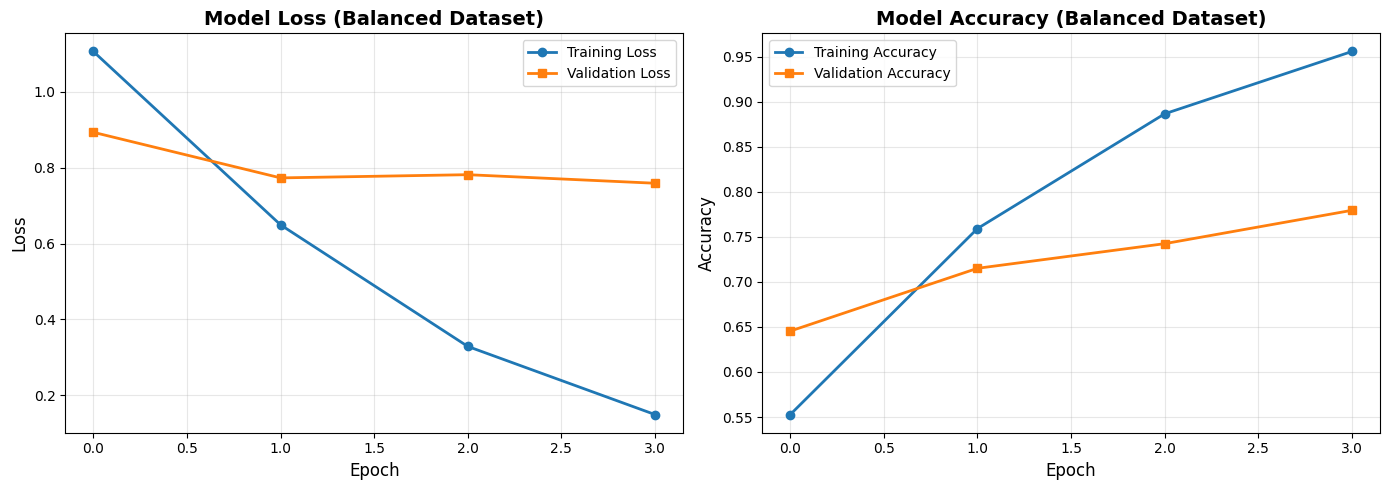

✅ Training plots saved!


In [6]:
# ----------------------------------------------------
# MODEL YÜKLE VE HISTORY'Yİ AL
# ----------------------------------------------------
print("\nLoading best model...")
try:
    checkpoint = torch.load('resnet18_balanced_emotion_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    history = checkpoint['history']
    print(f"✅ Best model loaded! (Trained for {checkpoint.get('epoch', len(history['train_loss']))} epochs)")
except FileNotFoundError:
    print("⚠️  Best model not found, using interrupted model...")
    checkpoint = torch.load('resnet18_interrupted_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    history = checkpoint['history']
    print(f"✅ Interrupted model loaded! (Trained for {checkpoint['epoch']} epochs)")


# ----------------------------------------------------
# PLOT - Loss ve Accuracy Grafikleri
# ----------------------------------------------------
print("\nGenerating training plots...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history['train_loss'], label='Training Loss', linewidth=2, marker='o')
ax1.plot(history['val_loss'], label='Validation Loss', linewidth=2, marker='s')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Model Loss (Balanced Dataset)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

ax2.plot(history['train_acc'], label='Training Accuracy', linewidth=2, marker='o')
ax2.plot(history['val_acc'], label='Validation Accuracy', linewidth=2, marker='s')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Model Accuracy (Balanced Dataset)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_plots_balanced.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Training plots saved!")




In [7]:
# ----------------------------------------------------
# TEST EVALUATION - Detaylı Metrikler
# ----------------------------------------------------
def evaluate_test(model, dataloader, device):
    model.eval()
    all_labels, all_preds = [], []
    with torch.no_grad():
        for inputs, labels, _ in tqdm(dataloader, desc='Testing'):
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(inputs)
            _, pred = outputs.max(1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(pred.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)


def calculate_sensitivity_specificity(y_true, y_pred, num_classes):
    cm = confusion_matrix(y_true, y_pred)

    sensitivity = []
    specificity = []

    for i in range(num_classes):
        tp = cm[i, i]
        fn = cm[i, :].sum() - tp
        fp = cm[:, i].sum() - tp
        tn = cm.sum() - (tp + fn + fp)

        sens = tp / (tp + fn) if (tp + fn) > 0 else 0
        sensitivity.append(sens)

        spec = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificity.append(spec)

    return sensitivity, specificity


print("\n" + "="*80)
print("TEST SET EVALUATION (BALANCED DATASET)")
print("="*80)

y_true, y_pred = evaluate_test(model, test_loader, device)

# Classification Report
print("\n📊 CLASSIFICATION REPORT:")
print("-"*80)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Balanced Accuracy
bal_acc = balanced_accuracy_score(y_true, y_pred)
print(f"\n🎯 BALANCED ACCURACY: {bal_acc:.4f}")

# Class-wise Sensitivity ve Specificity
sensitivity, specificity = calculate_sensitivity_specificity(y_true, y_pred, len(class_names))

print("\n📈 CLASS-WISE METRICS:")
print("-"*80)
print(f"{'Class':<20} {'Sensitivity':<15} {'Specificity':<15}")
print("-"*80)
for i, class_name in enumerate(class_names):
    print(f"{class_name:<20} {sensitivity[i]:<15.4f} {specificity[i]:<15.4f}")

print("-"*80)
print(f"{'AVERAGE':<20} {np.mean(sensitivity):<15.4f} {np.mean(specificity):<15.4f}")





TEST SET EVALUATION (BALANCED DATASET)


Testing: 100%|██████████| 94/94 [06:12<00:00,  3.97s/it]


📊 CLASSIFICATION REPORT:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

       Angry     0.7097    0.7742    0.7405      1200
        Fear     0.7433    0.6250    0.6790      1200
       Happy     0.8766    0.8525    0.8644      1200
         Sad     0.6724    0.7183    0.6946      1200
     Suprise     0.8881    0.9125    0.9001      1200

    accuracy                         0.7765      6000
   macro avg     0.7780    0.7765    0.7757      6000
weighted avg     0.7780    0.7765    0.7757      6000


🎯 BALANCED ACCURACY: 0.7765

📈 CLASS-WISE METRICS:
--------------------------------------------------------------------------------
Class                Sensitivity     Specificity    
--------------------------------------------------------------------------------
Angry                0.7742          0.9208         
Fear                 0.6250          0.9460         
Happy                0.8525    


Generating confusion matrices...


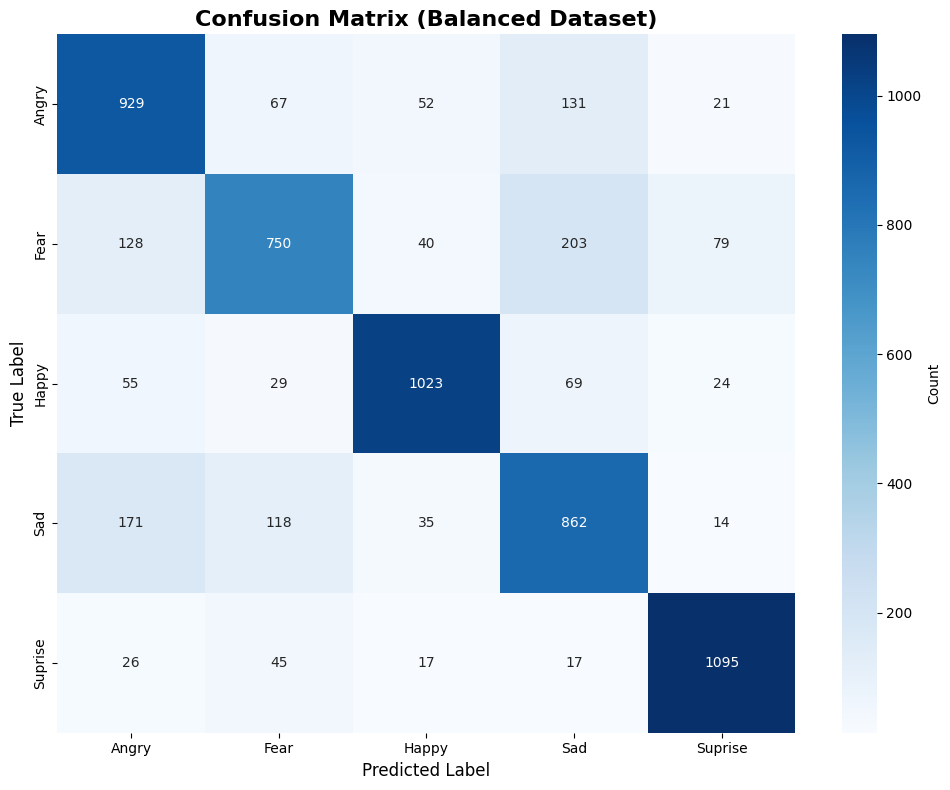

✅ Confusion matrix saved!


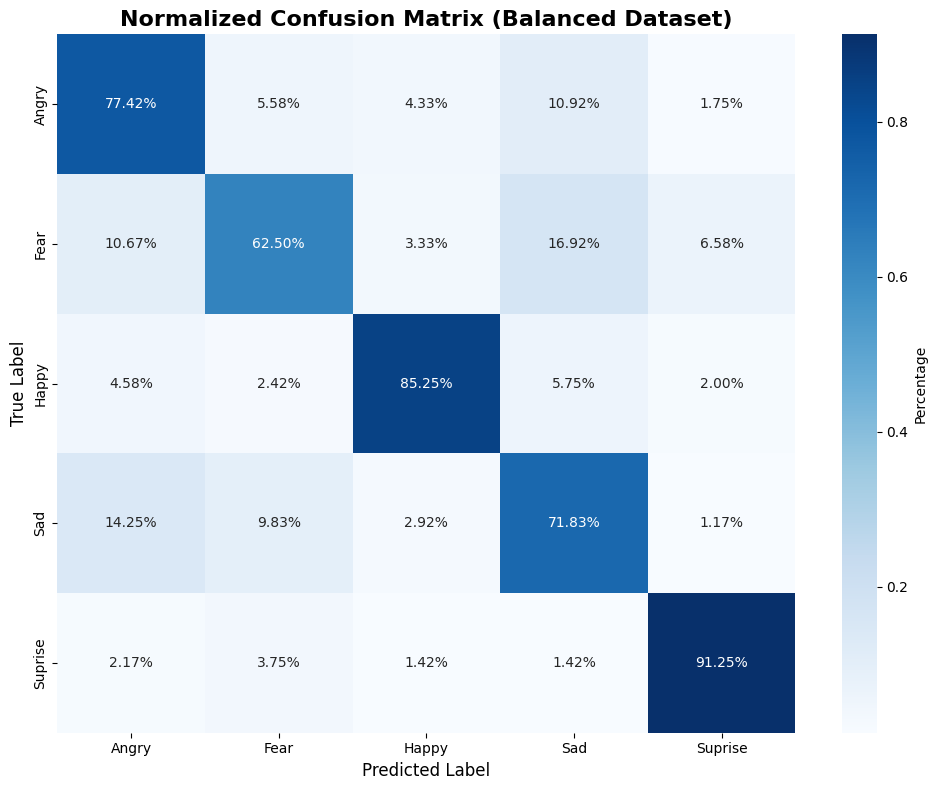

✅ Normalized confusion matrix saved!
✅ Test results saved!


In [8]:
# ----------------------------------------------------
# CONFUSION MATRIX
# ----------------------------------------------------
print("\nGenerating confusion matrices...")

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix (Balanced Dataset)', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix_balanced.png', dpi=300)
plt.show()
print("✅ Confusion matrix saved!")

# Normalized Confusion Matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Percentage'})
plt.title('Normalized Confusion Matrix (Balanced Dataset)', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix_normalized_balanced.png', dpi=300)
plt.show()
print("✅ Normalized confusion matrix saved!")


# ----------------------------------------------------
# SONUÇLARI KAYDET
# ----------------------------------------------------
results = {
    'balanced_accuracy': float(bal_acc),
    'class_names': class_names,
    'sensitivity': [float(s) for s in sensitivity],
    'specificity': [float(s) for s in specificity],
    'confusion_matrix': cm.tolist(),
    'training_epochs': len(history['train_loss']),
    'samples_per_class': 6000,
    'total_samples': len(image_paths),
    'train_samples': len(X_train),
    'val_samples': len(X_val),
    'test_samples': len(X_test)
}

with open('test_results_balanced.json', 'w') as f:
    json.dump(results, f, indent=4)

print("✅ Test results saved!")




In [10]:
# ============================================================
# GRAD-CAM VISUALIZATION
# ============================================================
print("\n" + "="*80)
print("GRAD-CAM VISUALIZATION")
print("="*80)

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def generate_cam(self, input_image, target_class=None):
        model_output = self.model(input_image)

        if target_class is None:
            # If target_class is not provided, determine it from model output
            # and convert to an integer.
            target_class_idx = model_output.argmax(dim=1).item()
        else:
            # If target_class is provided, it's already an integer (from pred_class).
            target_class_idx = target_class

        self.model.zero_grad()
        class_loss = model_output[0, target_class_idx]
        class_loss.backward()

        gradients = self.gradients[0].cpu().numpy()
        activations = self.activations[0].cpu().numpy()

        weights = np.mean(gradients, axis=(1, 2))

        cam = np.zeros(activations.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * activations[i]

        cam = np.maximum(cam, 0)

        if cam.max() > 0:
            cam = cam / cam.max()

        return cam, target_class_idx # Return the integer directly


def apply_colormap_on_image(org_im, activation, colormap=cv2.COLORMAP_JET):
    heatmap = cv2.applyColorMap(np.uint8(255 * activation), colormap)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = np.float32(heatmap) / 255

    if len(org_im.shape) == 2:
        org_im = np.stack([org_im] * 3, axis=-1)

    cam = heatmap + np.float32(org_im)
    cam = cam / np.max(cam)

    return np.uint8(255 * cam)


def visualize_gradcam(model, test_loader, class_names, num_samples=10, device='cuda'):
    model.eval()

    target_layer = model.resnet.layer4[-1].conv2
    gradcam = GradCAM(model, target_layer)

    indices = np.random.choice(len(test_loader.dataset), num_samples, replace=False)

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))

    for idx, sample_idx in enumerate(tqdm(indices, desc='Generating Grad-CAM')):
        img_tensor, true_label, img_path = test_loader.dataset[sample_idx]

        original_img = Image.open(img_path).convert('L')
        original_img_np = np.array(original_img.resize((224, 224))) / 255.0

        img_tensor = img_tensor.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(img_tensor)
            pred_class = output.argmax(dim=1).item()
            confidence = torch.softmax(output, dim=1)[0, pred_class].item()

        cam, _ = gradcam.generate_cam(img_tensor, target_class=pred_class)
        cam_resized = cv2.resize(cam, (224, 224))

        visualization = apply_colormap_on_image(original_img_np, cam_resized)

        axes[idx, 0].imshow(original_img_np, cmap='gray')
        axes[idx, 0].set_title(f'Original\nTrue: {class_names[true_label]}', fontsize=10)
        axes[idx, 0].axis('off')

        axes[idx, 1].imshow(cam_resized, cmap='jet')
        axes[idx, 1].set_title('Grad-CAM Heatmap', fontsize=10)
        axes[idx, 1].axis('off')

        axes[idx, 2].imshow(visualization)
        axes[idx, 2].set_title(f'Overlay\nPred: {class_names[pred_class]}\nConf: {confidence:.2%}', fontsize=10)
        axes[idx, 2].axis('off')

    plt.tight_layout()
    plt.savefig('gradcam_visualization_balanced.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✅ Grad-CAM visualization saved!")


visualize_gradcam(model, test_loader, class_names, num_samples=10, device=device)

print("\n" + "="*80)
print("🎉 ALL PROCESSING COMPLETED!")
print("="*80)
print("\n📁 Saved files:")
print("  ✓ resnet18_balanced_emotion_model.pth")
print("  ✓ training_plots_balanced.png")
print("  ✓ confusion_matrix_balanced.png")
print("  ✓ confusion_matrix_normalized_balanced.png")
print("  ✓ gradcam_visualization_balanced.png")
print("  ✓ test_results_balanced.json")
print("\n📊 Dataset Info:")
print(f"  ✓ Samples per class: 6000")
print(f"  ✓ Total samples: {len(image_paths)}")
print(f"  ✓ Number of classes: {len(class_names)}")
print("="*80)


Output hidden; open in https://colab.research.google.com to view.